In [1]:
import os
import math
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import plotly.graph_objs as go

# data loading and preprocessing

In [2]:
class ExchangeRateDataset(Dataset):
    def __init__(self, data_path, seq_len=96, pred_len=96, train=True):
        self.seq_len = seq_len
        self.pred_len = pred_len
        df = pd.read_csv(data_path)
        df = df.drop(columns=["date"])
        self.scaler = StandardScaler()
        data = self.scaler.fit_transform(df.values)  # shape: [num_samples, 8]
        split = int(len(data) * 0.8)
        self.data = data[:split] if train else data[split:]

    def __len__(self):
        return len(self.data) - self.seq_len - self.pred_len + 1

    def __getitem__(self, index):
        x = self.data[index : index + self.seq_len]      # [seq_len, 8]
        y = self.data[index + self.seq_len : index + self.seq_len + self.pred_len]  # [pred_len, 8]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# model::Transformer

In [3]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads):
        super().__init__()
        assert d_model % n_heads == 0, "d_model must be divisible by n_heads"
        self.d_head = d_model // n_heads
        self.n_heads = n_heads
        self.query = nn.Linear(d_model, d_model)
        self.key   = nn.Linear(d_model, d_model)
        self.value = nn.Linear(d_model, d_model)
        self.fc_out = nn.Linear(d_model, d_model)

    def forward(self, x, mask=None):
        B, L, D = x.shape
        Q = self.query(x).view(B, L, self.n_heads, self.d_head).transpose(1,2)
        K = self.key(x).view(B, L, self.n_heads, self.d_head).transpose(1,2)
        V = self.value(x).view(B, L, self.n_heads, self.d_head).transpose(1,2)
        scores = torch.matmul(Q, K.transpose(-2,-1)) / math.sqrt(self.d_head)
        if mask is not None:
            scores = scores.masked_fill(mask==0, float('-inf'))
        attn = F.softmax(scores, dim=-1)
        out = torch.matmul(attn, V)
        out = out.transpose(1,2).contiguous().view(B, L, D)
        return self.fc_out(out)

In [4]:
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_ff, d_model)
        )
    def forward(self, x):
        return self.net(x)

In [5]:
class TransformerBlock(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, dropout=0.1):
        super().__init__()
        self.attention = MultiHeadAttention(d_model, n_heads)
        self.norm1 = nn.LayerNorm(d_model)
        self.ffn = FeedForward(d_model, d_ff, dropout)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
    def forward(self, x):
        attn_out = self.attention(x)
        x = self.norm1(x + self.dropout(attn_out))
        ffn_out = self.ffn(x)
        return self.norm2(x + self.dropout(ffn_out))

In [6]:
class Transformer(nn.Module):
    def __init__(self, seq_len, pred_len, num_features=8, d_model=128, n_heads=4, d_ff=256, num_layers=2, dropout=0.1):
        super().__init__()
        self.seq_len = seq_len
        self.pred_len = pred_len
        # Project the 8 features at each time step to d_model
        self.input_proj = nn.Linear(num_features, d_model)
        self.transformer_blocks = nn.ModuleList(
            [TransformerBlock(d_model, n_heads, d_ff, dropout) for _ in range(num_layers)]
        )
        self.fc_out = nn.Linear(d_model, num_features)

    def forward(self, x):
        # x: [B, seq_len, num_features]
        x = self.input_proj(x)  # [B, seq_len, d_model]
        for block in self.transformer_blocks:
            x = block(x)
        last = x[:, -1, :]  # [B, d_model]
        # For forecasting, we take the last time-step representation and repeat it pred_len times, then map back to 8 features.
        repeated = last.unsqueeze(1).repeat(1, self.pred_len, 1)  # [B, pred_len, d_model]
        out = self.fc_out(repeated)  # [B, pred_len, num_features]
        return out

In [7]:
# class EncoderLayer(nn.Module):
#     def __init__(self, attention, d_model, d_ff=None, dropout=0.1, activation="gelu"):
#         super().__init__()
#         d_ff = d_ff or 4 * d_model
#         self.attention = attention
#         self.norm1 = nn.LayerNorm(d_model)
#         self.ffn = nn.Sequential(
#             nn.Linear(d_model, d_ff),
#             nn.GELU() if activation=="gelu" else nn.ReLU(),
#             nn.Dropout(dropout),
#             nn.Linear(d_ff, d_model)
#         )
#         self.norm2 = nn.LayerNorm(d_model)
#         self.dropout = nn.Dropout(dropout)
#     def forward(self, x, attn_mask=None, tau=None, delta=None):
#         new_x, attn = self.attention(x, x, x, attn_mask, tau, delta)
#         x = self.norm1(x + self.dropout(new_x))
#         new_x = self.ffn(x)
#         x = self.norm2(x + self.dropout(new_x))
#         return x, attn

# class Encoder(nn.Module):
#     def __init__(self, attn_layers, norm_layer=None):
#         super().__init__()
#         self.attn_layers = nn.ModuleList(attn_layers)
#         self.norm = norm_layer
#     def forward(self, x, attn_mask=None, tau=None, delta=None):
#         attns = []
#         for layer in self.attn_layers:
#             x, attn = layer(x, attn_mask, tau, delta)
#             attns.append(attn)
#         if self.norm is not None:
#             x = self.norm(x)
#         return x, attns

In [8]:
# class FullAttention(nn.Module):
#     def __init__(self, mask_flag=True, factor=1, scale=None, attention_dropout=0.1, output_attention=False):
#         super().__init__()
#         self.mask_flag = mask_flag
#         self.output_attention = output_attention
#         self.dropout = nn.Dropout(attention_dropout)
#         self.scale = scale or 1.0
#     def forward(self, queries, keys, values, attn_mask=None, tau=None, delta=None):
#         scores = torch.matmul(queries, keys.transpose(-2, -1)) / math.sqrt(queries.shape[-1])
#         if self.mask_flag and attn_mask is not None:
#             scores = scores.masked_fill(attn_mask, float('-inf'))
#         attn = F.softmax(scores, dim=-1)
#         attn = self.dropout(attn)
#         out = torch.matmul(attn, values)
#         if self.output_attention:
#             return out, attn
#         else:
#             return out, None

# class AttentionLayer(nn.Module):
#     def __init__(self, attention, d_model, n_heads, d_keys=None, d_values=None):
#         super().__init__()
#         d_keys = d_keys or (d_model // n_heads)
#         d_values = d_values or (d_model // n_heads)
#         self.n_heads = n_heads
#         self.query_projection = nn.Linear(d_model, d_keys * n_heads)
#         self.key_projection = nn.Linear(d_model, d_keys * n_heads)
#         self.value_projection = nn.Linear(d_model, d_values * n_heads)
#         self.out_projection = nn.Linear(d_values * n_heads, d_model)
#         self.inner_attention = attention
#     def forward(self, queries, keys, values, attn_mask=None, tau=None, delta=None):
#         B, L, _ = queries.shape
#         _, S, _ = keys.shape
#         H = self.n_heads
#         queries = self.query_projection(queries).view(B, L, H, -1)
#         keys = self.key_projection(keys).view(B, S, H, -1)
#         values = self.value_projection(values).view(B, S, H, -1)
#         out, attn = self.inner_attention(queries, keys, values, attn_mask, tau, delta)
#         out = out.view(B, L, -1)
#         out = self.out_projection(out)
#         return out, attn

# model::iTransformer

In [7]:
# DataEmbedding_inverted: embeds the (inverted) time-series.
class DataEmbedding_inverted(nn.Module):
    def __init__(self, c_in, d_model, dropout=0.1):
        super(DataEmbedding_inverted, self).__init__()
        self.value_embedding = nn.Linear(c_in, d_model)
        self.dropout = nn.Dropout(p=dropout)
    def forward(self, x, x_mark):
        # x: [B, T, N] where T = seq_len, N = number of variates.
        # Inversion: treat T as channels.
        x = x.permute(0, 2, 1)  # now: [B, N, T]
        # (If x_mark is provided, one could concatenate; here we assume None.)
        x = self.value_embedding(x)  # [B, N, d_model]
        return self.dropout(x)

In [8]:
# class iTransformer(nn.Module):
#     def __init__(self, configs):
#         super(iTransformer, self).__init__()
#         self.seq_len = configs.seq_len
#         self.pred_len = configs.pred_len
#         self.output_attention = configs.output_attention
#         self.use_norm = configs.use_norm
#         # Embedding: note that we pass the lookback length (seq_len) as c_in.
#         self.enc_embedding = DataEmbedding_inverted(configs.seq_len, configs.d_model, configs.embed, configs.freq, configs.dropout)
#         self.class_strategy = configs.class_strategy
#         # Encoder-only architecture: build e_layers of EncoderLayer
#         self.encoder = Encoder(
#             [
#                 EncoderLayer(
#                     AttentionLayer(
#                         FullAttention(False, configs.factor, attention_dropout=configs.dropout,
#                                       output_attention=configs.output_attention),
#                         configs.d_model, configs.n_heads),
#                     configs.d_model,
#                     configs.d_ff,
#                     dropout=configs.dropout,
#                     activation=configs.activation
#                 ) for l in range(configs.e_layers)
#             ],
#             norm_layer=nn.LayerNorm(configs.d_model)
#         )
#         self.projector = nn.Linear(configs.d_model, configs.pred_len, bias=True)

#     def forecast(self, x_enc, x_mark_enc, x_dec, x_mark_dec):
#         if self.use_norm:
#             means = x_enc.mean(1, keepdim=True).detach()
#             x_enc = x_enc - means
#             stdev = torch.sqrt(torch.var(x_enc, dim=1, keepdim=True, unbiased=False) + 1e-5)
#             x_enc /= stdev
#         # x_enc shape: [B, seq_len, N] where N=number of variates (8)
#         # After embedding, we get: [B, N, d_model] because DataEmbedding_inverted permutes.
#         enc_out = self.enc_embedding(x_enc, x_mark_enc)
#         enc_out, attns = self.encoder(enc_out, attn_mask=None)
#         # Project: enc_out is [B, N, d_model] → projector maps each token to pred_len
#         # Then permute to [B, pred_len, N]; finally, we “filter” the tokens (variates) by [:, :, :N].
#         dec_out = self.projector(enc_out).permute(0, 2, 1)[:, :, :x_enc.shape[-1]]
#         if self.use_norm:
#             dec_out = dec_out * (stdev[:, 0, :].unsqueeze(1).repeat(1, self.pred_len, 1))
#             dec_out = dec_out + (means[:, 0, :].unsqueeze(1).repeat(1, self.pred_len, 1))
#         return dec_out

#     def forward(self, x_enc, x_mark_enc, x_dec, x_mark_dec, mask=None):
#         dec_out = self.forecast(x_enc, x_mark_enc, x_dec, x_mark_dec)
#         return dec_out[:, -self.pred_len:, :]  # [B, pred_len, N]




class iTransformer(nn.Module):
    def __init__(self, configs):
        super(iTransformer, self).__init__()
        self.seq_len = configs.seq_len
        self.pred_len = configs.pred_len
        self.output_attention = configs.output_attention
        self.use_norm = configs.use_norm

        # Embedding: transpose and embed the series into variate tokens
        self.enc_embedding = DataEmbedding_inverted(configs.seq_len, configs.d_model, configs.embed, configs.freq, configs.dropout)

        # Use MultiHeadAttention instead of FullAttention
        self.attention = MultiHeadAttention(configs.d_model, configs.n_heads)  # Change to MultiHeadAttention

        self.projector = nn.Linear(configs.d_model, configs.pred_len, bias=True)  # For forecasting

    def forecast(self, x_enc, x_mark_enc, x_dec, x_mark_dec):
        if self.use_norm:
            means = x_enc.mean(1, keepdim=True).detach()
            x_enc = x_enc - means
            stdev = torch.sqrt(torch.var(x_enc, dim=1, keepdim=True, unbiased=False) + 1e-5)
            x_enc /= stdev

        # Apply embedding
        enc_out = self.enc_embedding(x_enc, x_mark_enc)

        # Use MultiHeadAttention for the encoding part (as per pseudocode)
        attention_out = self.attention(enc_out)  # Apply attention directly

        # Project the output to the required shape for forecasting
        dec_out = self.projector(attention_out).permute(0, 2, 1)[:, :, :x_enc.shape[-1]]

        if self.use_norm:
            dec_out = dec_out * (stdev[:, 0, :].unsqueeze(1).repeat(1, self.pred_len, 1))
            dec_out = dec_out + (means[:, 0, :].unsqueeze(1).repeat(1, self.pred_len, 1))

        return dec_out

    def forward(self, x_enc, x_mark_enc, x_dec, x_mark_dec, mask=None):
        dec_out = self.forecast(x_enc, x_mark_enc, x_dec, x_mark_dec)
        return dec_out[:, -self.pred_len:, :]  # [B, pred_len, N]


# train

In [9]:
def train_model(model, train_loader, criterion, optimizer, num_epochs, device):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for x_batch, y_batch in train_loader:
            x_batch = x_batch.to(device)   # [B, seq_len, 8]
            y_batch = y_batch.to(device)   # [B, pred_len, 8]
            optimizer.zero_grad()
            output = model(x_batch)  # for Transformer model: output shape [B, pred_len, 8]
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {total_loss/len(train_loader):.4f}")
    return model

In [10]:
# For iTransformer, note its forward signature is different:
def train_model_itrans(model, train_loader, criterion, optimizer, num_epochs, device):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for x_batch, y_batch in train_loader:
            x_batch = x_batch.to(device)   # [B, seq_len, 8]
            y_batch = y_batch.to(device)   # [B, pred_len, 8]
            optimizer.zero_grad()
            # For iTransformer, we pass dummy decoder inputs and marks (set to None)
            dummy_dec = torch.zeros_like(y_batch).to(device)
            out = model(x_batch, None, dummy_dec, None)  # output shape: [B, pred_len, 8]
            loss = criterion(out, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"iTransformer Epoch [{epoch+1}/{num_epochs}] Loss: {total_loss/len(train_loader):.4f}")
    return model

# evaluation

In [11]:
def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            out = model(x_batch)
            preds.append(out.cpu().numpy())
            trues.append(y_batch.cpu().numpy())
    preds = np.concatenate(preds, axis=0)
    trues = np.concatenate(trues, axis=0)
    mse = np.mean((preds - trues)**2)
    mae = np.mean(np.abs(preds - trues))

    # Plot predictions vs ground truth for each prediction length using Matplotlib
    # if not os.path.exists("plots"):
    #     os.makedirs("plots")

    # plt.figure(figsize=(10, 6))
    # plt.plot(trues.ravel(), label='Ground Truth', color='blue')
    # plt.plot(preds.ravel(), label='Prediction', color='orange')
    # plt.title(f"Transformer Predictions (Prediction Length: {pred_len})")
    # plt.xlabel('Time Step')
    # plt.ylabel('Exchange Rate')
    # plt.legend()
    # plt.savefig(f"plots/trans_pred_len_{pred_len}.pdf")
    # plt.close()
    return mse, mae, preds, trues

In [12]:
def evaluate_model_itrans(model, test_loader, criterion, device):
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            dummy_dec = torch.zeros_like(y_batch).to(device)
            out = model(x_batch, None, dummy_dec, None)
            preds.append(out.cpu().numpy())
            trues.append(y_batch.cpu().numpy())
    preds = np.concatenate(preds, axis=0)
    trues = np.concatenate(trues, axis=0)
    mse = np.mean((preds - trues)**2)
    mae = np.mean(np.abs(preds - trues))

    # Plot predictions vs ground truth for each prediction length using Matplotlib
    # if not os.path.exists("plots"):
    #     os.makedirs("plots")

    # plt.figure(figsize=(10, 6))
    # plt.plot(trues.ravel(), label='Ground Truth', color='blue')
    # plt.plot(preds.ravel(), label='Prediction', color='orange')
    # plt.title(f"iTransformer Predictions (Prediction Length: {pred_len})")
    # plt.xlabel('Time Step')
    # plt.ylabel('Exchange Rate')
    # plt.legend()
    # plt.savefig(f"plots/itrans_pred_len_{pred_len}.pdf")
    # plt.close()
    return mse, mae, preds, trues

# main

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"
data_path = "/content/drive/MyDrive/datasets/exchange_rate.csv"  # update with your dataset path

# Prediction lengths to test
pred_lengths = [96, 192, 336, 720]
T = 96  # fixed lookback

# We'll store metrics for both models across pred_lengths
results_transformer = []
results_itransformer = []

# Use MSE loss for both models
criterion = nn.MSELoss()

# Number of epochs (for demonstration, use a small number)
num_epochs = 20

In [14]:
# Lists to store predictions and ground truth for each prediction length
all_preds_t = []
all_trues_t = []
all_preds_it = []
all_trues_it = []

for pred_len in pred_lengths:
    print(f"\n=== Experiment: Lookback T = {T} and Prediction Length = {pred_len} ===")
    # Create datasets and loaders
    train_dataset = ExchangeRateDataset(data_path, seq_len=T, pred_len=pred_len, train=True)
    test_dataset  = ExchangeRateDataset(data_path, seq_len=T, pred_len=pred_len, train=False)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # ---- Transformer Experiment ----
    model_transformer = Transformer(seq_len=T, pred_len=pred_len, num_features=8,
                                    d_model=128, n_heads=4, d_ff=256, num_layers=2, dropout=0.1).to(device)
    optimizer_t = torch.optim.Adam(model_transformer.parameters(), lr=0.001)
    print("\nTraining Transformer...")
    model_transformer = train_model(model_transformer, train_loader, criterion, optimizer_t, num_epochs, device)
    mse_t, mae_t, preds_t, trues_t = evaluate_model(model_transformer, test_loader, criterion, device)
    print(f"Transformer Prediction Length {pred_len} -- MSE: {mse_t:.4f}, MAE: {mae_t:.4f}")
    results_transformer.append((mse_t, mae_t))

    # Append results for Transformer
    all_preds_t.append(preds_t)
    all_trues_t.append(trues_t)

    # ---- iTransformer Experiment ----
    # Build a configuration object (using a simple namespace)
    from types import SimpleNamespace
    config = SimpleNamespace(
        seq_len = T,
        pred_len = pred_len,
        output_attention = False,
        use_norm = True,
        # embed = "fixed",
        # freq = "h",
        dropout = 0.1,
        d_model = 128,
        n_heads = 4,
        d_ff = 256,
        e_layers = 2,
        factor = 1,
        activation = "gelu",
        class_strategy = "projection"
    )
    model_itransformer = iTransformer(config).to(device)
    optimizer_it = torch.optim.Adam(model_itransformer.parameters(), lr=0.001)
    print("\nTraining iTransformer...")
    model_itransformer = train_model_itrans(model_itransformer, train_loader, criterion, optimizer_it, num_epochs, device)
    mse_it, mae_it, preds_it, trues_it = evaluate_model_itrans(model_itransformer, test_loader, criterion, device)
    print(f"iTransformer Prediction Length {pred_len} -- MSE: {mse_it:.4f}, MAE: {mae_it:.4f}")
    results_itransformer.append((mse_it, mae_it))

    # Append results for iTransformer
    all_preds_it.append(preds_it)
    all_trues_it.append(trues_it)


=== Experiment: Lookback T = 96 and Prediction Length = 96 ===

Training Transformer...
Epoch [1/20] Loss: 0.0920
Epoch [2/20] Loss: 0.0517
Epoch [3/20] Loss: 0.0442
Epoch [4/20] Loss: 0.0391
Epoch [5/20] Loss: 0.0367
Epoch [6/20] Loss: 0.0354
Epoch [7/20] Loss: 0.0346
Epoch [8/20] Loss: 0.0338
Epoch [9/20] Loss: 0.0332
Epoch [10/20] Loss: 0.0330
Epoch [11/20] Loss: 0.0328
Epoch [12/20] Loss: 0.0322
Epoch [13/20] Loss: 0.0319
Epoch [14/20] Loss: 0.0315
Epoch [15/20] Loss: 0.0314
Epoch [16/20] Loss: 0.0311
Epoch [17/20] Loss: 0.0310
Epoch [18/20] Loss: 0.0312
Epoch [19/20] Loss: 0.0311
Epoch [20/20] Loss: 0.0307
Transformer Prediction Length 96 -- MSE: 0.5669, MAE: 0.6230

Training iTransformer...
iTransformer Epoch [1/20] Loss: 0.0929
iTransformer Epoch [2/20] Loss: 0.0854
iTransformer Epoch [3/20] Loss: 0.0838
iTransformer Epoch [4/20] Loss: 0.0822
iTransformer Epoch [5/20] Loss: 0.0819
iTransformer Epoch [6/20] Loss: 0.0808
iTransformer Epoch [7/20] Loss: 0.0797
iTransformer Epoch [

In [37]:
!pip install -U kaleido

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 7.6 MB/s eta 0:00:00


In [15]:
avg_mse_transformer = np.mean([r[0] for r in results_transformer])
avg_mae_transformer = np.mean([r[1] for r in results_transformer])
avg_mse_itransformer = np.mean([r[0] for r in results_itransformer])
avg_mae_itransformer = np.mean([r[1] for r in results_itransformer])

print("\n=== Average Results Over All Prediction Lengths ===")
print(f"Transformer Average -- MSE: {avg_mse_transformer:.4f}, MAE: {avg_mae_transformer:.4f}")
print(f"iTransformer Average -- MSE: {avg_mse_itransformer:.4f}, MAE: {avg_mae_itransformer:.4f}")


=== Average Results Over All Prediction Lengths ===
Transformer Average -- MSE: 0.6996, MAE: 0.6747
iTransformer Average -- MSE: 0.2479, MAE: 0.3364


# plot

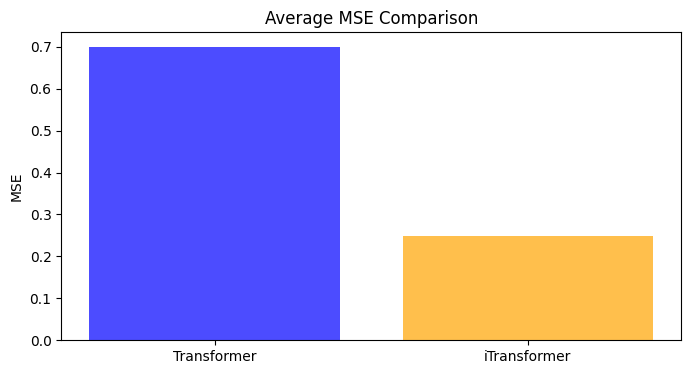

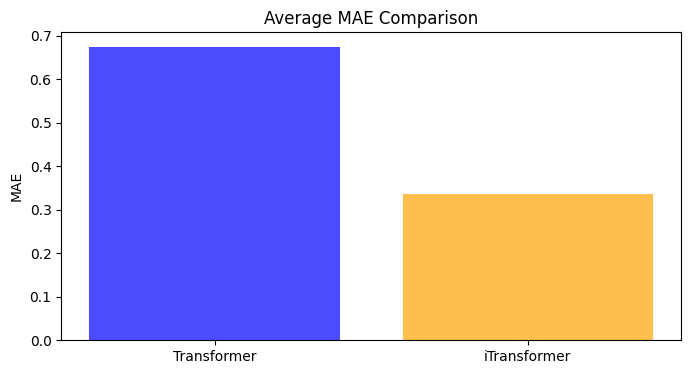

In [16]:
models = ["Transformer", "iTransformer"]
avg_mse = [avg_mse_transformer, avg_mse_itransformer]
avg_mae = [avg_mae_transformer, avg_mae_itransformer]

plt.figure(figsize=(8, 4))
plt.bar(models, avg_mse, color=['blue', 'orange'], alpha=0.7)
plt.ylabel("MSE")
plt.title("Average MSE Comparison")
plt.show()

plt.figure(figsize=(8, 4))
plt.bar(models, avg_mae, color=['blue', 'orange'], alpha=0.7)
plt.ylabel("MAE")
plt.title("Average MAE Comparison")
plt.show()


In [17]:
import plotly.graph_objects as go
import numpy as np
import pandas as pd

# Helper function for plotting ground truth and predictions per feature
def plot_predictions(predictions, ground_truth, feature_names):
    """
    Plot predictions vs. ground truth for each of the 8 features using Plotly.

    Parameters:
    - predictions: np.array of shape [num_samples, pred_len, num_features]
    - ground_truth: np.array of shape [num_samples, pred_len, num_features]
    - feature_names: list of feature names for labeling the plots
    """
    num_features = predictions.shape[-1]
    pred_len = predictions.shape[1]
    sample_idx = 0  # Plotting for the first sample

    for feature_idx in range(num_features):
        feature_name = feature_names[feature_idx] if feature_names else f"Feature {feature_idx + 1}"
        fig = go.Figure()

        # Plot ground truth
        fig.add_trace(go.Scatter(
            y=ground_truth[sample_idx, :, feature_idx],
            x=list(range(pred_len)),
            mode='lines',
            name=f'{feature_name} Ground Truth',
            line=dict(color='blue')
        ))

        # Plot predictions
        fig.add_trace(go.Scatter(
            y=predictions[sample_idx, :, feature_idx],
            x=list(range(pred_len)),
            mode='lines',
            name=f'{feature_name} Prediction',
            line=dict(color='orange')
        ))

        # Layout and labels
        fig.update_layout(
            title=f'{feature_name}: Predictions vs Ground Truth',
            xaxis_title='Time Steps',
            yaxis_title='Value',
            showlegend=True
        )

        fig.show()

# Assuming evaluation results already obtained from evaluate_model
# Dummy feature names for illustration
feature_names = [f"Feature {i + 1}" for i in range(8)]

# Use these lines after obtaining preds and trues
# Example invocation of plotting
# predictions = np.random.rand(1, 96, 8)  # Replace with actual predictions
# ground_truth = np.random.rand(1, 96, 8)  # Replace with actual ground truths

plot_predictions(preds_it, trues_it, feature_names)


In [55]:
preds_t.shape

(703, 720, 8)

In [56]:
trues_t.shape

(703, 720, 8)

In [20]:
def plot_pred2(predictions, ground_truth, feature_names, flag):
    num_features = predictions.shape[-1]
    pred_len = predictions.shape[1]
    sample_idx = 0  # Plotting for the first sample

    # Set up the figure for multiple subplots
    fig, axes = plt.subplots(num_features, 1, figsize=(10, 2 * num_features))

    for feature_idx in range(num_features):
        feature_name = feature_names[feature_idx] if feature_names else f"Feature {feature_idx + 1}"

        # Plot ground truth
        axes[feature_idx].plot(range(pred_len), ground_truth[sample_idx, :, feature_idx], color='blue', label=f'{feature_name} Ground Truth')

        # Plot predictions
        axes[feature_idx].plot(range(pred_len), predictions[sample_idx, :, feature_idx], color='orange', label=f'{feature_name} Prediction')

        # Labeling
        axes[feature_idx].set_title(f'{feature_name}: Predictions vs Ground Truth')
        axes[feature_idx].set_xlabel('Time Steps')
        axes[feature_idx].set_ylabel('Value')
        axes[feature_idx].legend()

    # Adjust layout for better spacing between subplots
    plt.tight_layout()

    # Save the figure as a PDF
    plt.savefig(f'{flag}-predictions_vs_ground_truth.pdf')

    # Close the plot to avoid it from showing
    plt.close()


# plot_pred2(preds_it, trues_it, feature_names, flag='itrans')

In [18]:
# Inverse transform predictions and ground truth to the original scale
scaler = train_dataset.scaler  # Assuming the scaler is the same for both training and testing data

# Inverse transform the predictions and ground truth
preds_t_inv = scaler.inverse_transform(preds_t.reshape(-1, preds_t.shape[-1])).reshape(preds_t.shape)
trues_t_inv = scaler.inverse_transform(trues_t.reshape(-1, trues_t.shape[-1])).reshape(trues_t.shape)

preds_it_inv = scaler.inverse_transform(preds_it.reshape(-1, preds_it.shape[-1])).reshape(preds_it.shape)
trues_it_inv = scaler.inverse_transform(trues_it.reshape(-1, trues_it.shape[-1])).reshape(trues_it.shape)


In [68]:
# For Transformer model
plot_pred2(preds_t_inv, trues_t_inv, feature_names, flag='trans-inv')

# For iTransformer model
plot_pred2(preds_it_inv, trues_it_inv, feature_names, flag='itrans-inv')


In [21]:
# Loop through each set of predictions and ground truth for each prediction length
for idx, pred_len in enumerate(pred_lengths):
    preds_t = all_preds_t[idx]  # Transformer predictions
    trues_t = all_trues_t[idx]  # Transformer ground truth

    preds_it = all_preds_it[idx]  # iTransformer predictions
    trues_it = all_trues_it[idx]  # iTransformer ground truth

    # Plot Transformer predictions and ground truth
    plot_pred2(preds_t, trues_t, feature_names, flag=f'trans-inv-{pred_len}')

    # Plot iTransformer predictions and ground truth
    plot_pred2(preds_it, trues_it, feature_names, flag=f'itrans-inv-{pred_len}')
